In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import random
import seaborn as sns
import scipy
import statsmodels.api as sm
import warnings


from pmdarima.arima import auto_arima
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_excel("../Series/TRM.xlsx", index_col = 'Fecha', parse_dates= True)

In [3]:
df = df.resample("M").mean()

In [5]:
df['logs'] = np.log(df.TRM)

In [6]:
df['shift_logs'] = df.logs.shift(1)

In [7]:
df['returns']  = (df.logs - df.shift_logs)*100

In [8]:
avg_returns = df.returns.mean()

In [9]:
avg_returns

0.5403410052212074

In [10]:
df['sq_dem_ret_2'] = (df.returns - avg_returns)**2

In [11]:
df = df.dropna()

In [15]:
df

,TRM,logs,shift_logs,returns,sq_dem_ret_2
Fecha,,,,,
1992-01-31,644.058065,6.467789,6.446374,2.141439,2.563515
1992-02-29,635.671724,6.454682,6.467789,-1.310661,3.426209
1992-03-31,640.501935,6.462252,6.454682,0.756987,0.046935
1992-04-30,649.955000,6.476903,6.462252,1.465099,0.855177
1992-05-31,659.771290,6.491893,6.476903,1.499012,0.919049
...,...,...,...,...,...
2022-11-30,4926.660667,8.502417,8.457832,4.458497,15.351949
2022-12-31,4788.490645,8.473971,8.502417,-2.844615,11.457929
2023-01-31,4715.203871,8.458547,8.473971,-1.542310,4.337436


In [18]:
timeseries = df[["sq_dem_ret_2"]].values.astype('float32')

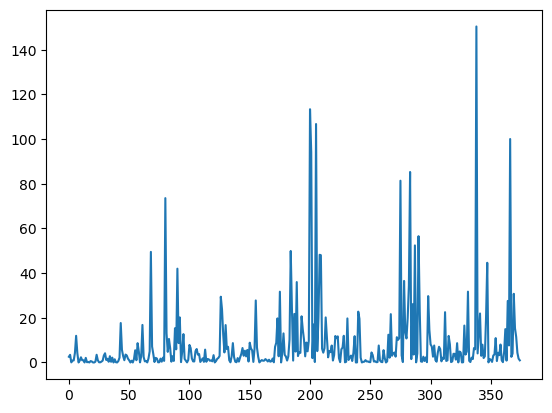

In [21]:
plt.plot(timeseries)
plt.show()

In [40]:
train_size = int(len(timeseries) * 0.95)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [41]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [49]:
lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([344, 12, 1]) torch.Size([344, 12, 1])
torch.Size([7, 12, 1]) torch.Size([7, 12, 1])


In [50]:
import torch.nn as nn
 
class XRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [52]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = XRModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 17.7002, test RMSE 30.4014
Epoch 100: train RMSE 13.4548, test RMSE 29.2390
Epoch 200: train RMSE 9.6167, test RMSE 27.8915
Epoch 300: train RMSE 8.0372, test RMSE 28.2671
Epoch 400: train RMSE 7.4382, test RMSE 28.0809
Epoch 500: train RMSE 7.0301, test RMSE 27.0752
Epoch 600: train RMSE 6.7706, test RMSE 25.7833
Epoch 700: train RMSE 6.5921, test RMSE 25.0017
Epoch 800: train RMSE 6.4583, test RMSE 24.3234
Epoch 900: train RMSE 6.3697, test RMSE 24.3330
Epoch 1000: train RMSE 6.2930, test RMSE 24.3419
Epoch 1100: train RMSE 6.2311, test RMSE 24.5237
Epoch 1200: train RMSE 6.1458, test RMSE 23.8078
Epoch 1300: train RMSE 6.1159, test RMSE 23.5546
Epoch 1400: train RMSE 6.0456, test RMSE 24.0668
Epoch 1500: train RMSE 5.9913, test RMSE 23.7488
Epoch 1600: train RMSE 5.9452, test RMSE 23.0729
Epoch 1700: train RMSE 5.9077, test RMSE 22.6677
Epoch 1800: train RMSE 5.8516, test RMSE 22.6409
Epoch 1900: train RMSE 5.8051, test RMSE 22.5503


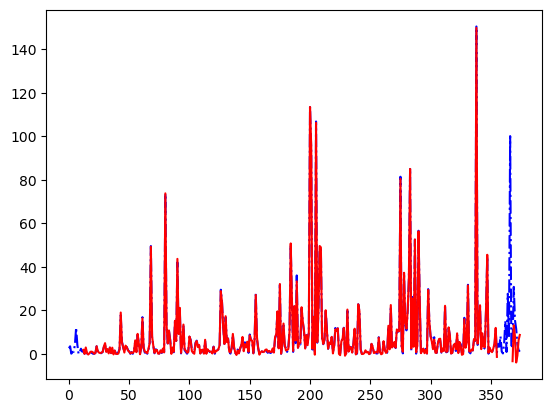

In [53]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b', linestyle = '-.')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='r')
plt.show()

In [12]:
model = auto_arima(df.sq_dem_ret_2, 
    start_p = 0, max_p = 12, 
    d = 0, max_d = 1, 
    start_q = 0,  max_q = 12,
    information_criterion="bic", 
    with_intercept = True, 
    stepwise = False, 
    method = "lbfgs",
    seasonal = False,
    trace = 1)

 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=3195.902, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=3194.493, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=3199.002, Time=0.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : BIC=3203.316, Time=0.28 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : BIC=3203.200, Time=0.31 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : BIC=3205.499, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=3193.495, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=3184.858, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=3190.783, Time=0.35 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : BIC=3194.965, Time=0.41 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : BIC=3199.418, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=3197.657, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=3190.784, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=3196.324, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : BIC=3202.197, Time=0.47 sec
 ARIMA(3,0

In [13]:
final_ARMA = ARIMA(df.sq_dem_ret_2, order=(1, 0, 1)).fit()

In [14]:
print(final_ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:           sq_dem_ret_2   No. Observations:                  375
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1580.575
Date:                Wed, 12 Apr 2023   AIC                           3169.150
Time:                        22:28:21   BIC                           3184.858
Sample:                    01-31-1992   HQIC                          3175.386
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1531      4.034      2.021      0.043       0.246      16.060
ar.L1          0.9196      0.051     17.985      0.000       0.819       1.020
ma.L1         -0.8217      0.071    -11.594      0.0

In [60]:
new = final_ARMA.get_prediction('1992-01-31', '2023-03-31')

In [67]:
new.predicted_mean

Fecha
1992-01-31     8.153141
1992-02-29     7.337171
1992-03-31     6.897739
1992-04-30     6.187083
1992-05-31     5.750325
                ...    
2022-11-30    14.854574
2022-12-31    14.364439
2023-01-31    13.580403
2023-02-28    12.238938
2023-03-31    10.879205
Freq: M, Name: predicted_mean, Length: 375, dtype: float64

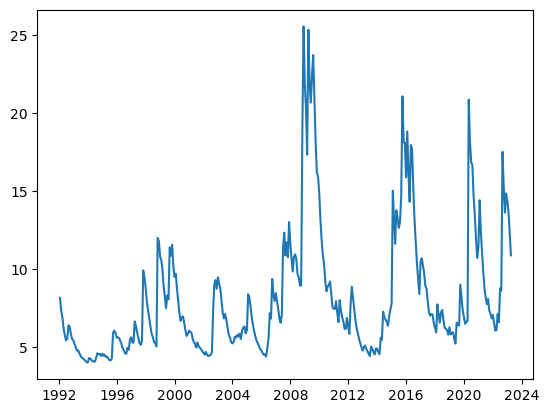

In [66]:
plt.plot(new.predicted_mean)

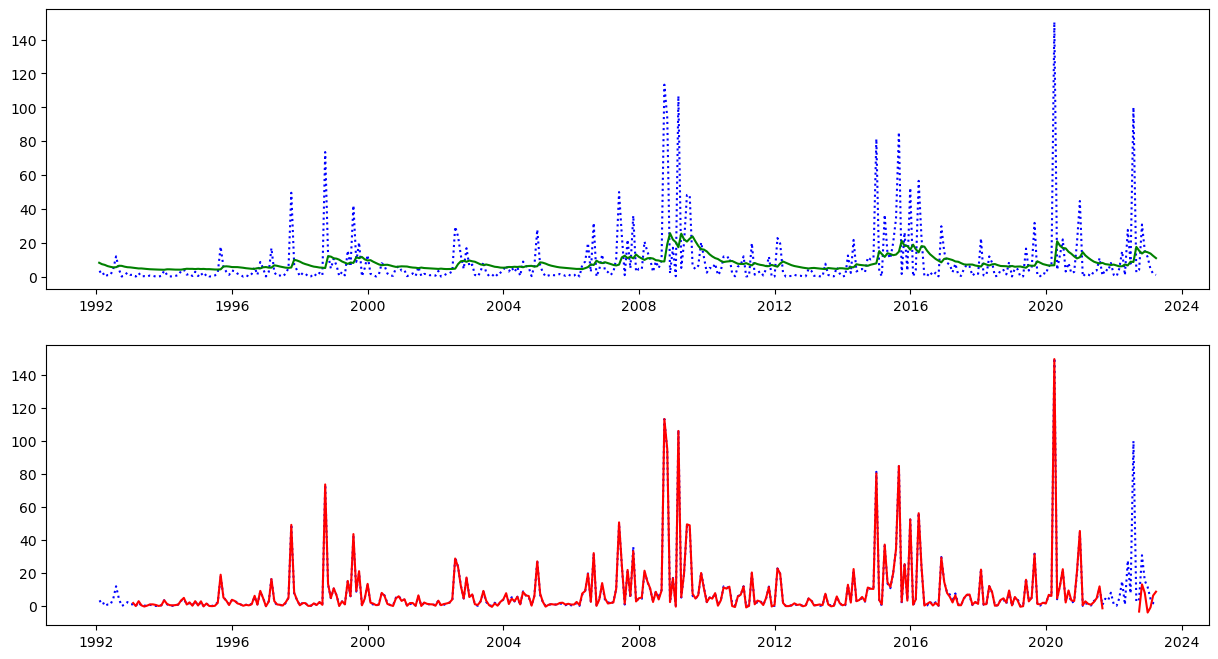

In [86]:
fig, ax =plt.subplots(2,1, figsize=(15,8), sharex = False)
ax[0].plot(new.predicted_mean.index, timeseries, c='b', linestyle = ':')
ax[0].plot(new.predicted_mean, c='g')
ax[1].plot(new.predicted_mean.index, timeseries, c='b', linestyle = ':')
ax[1].plot(new.predicted_mean.index,train_plot, c='r')
ax[1].plot(new.predicted_mean.index,test_plot, c='r')